In [1]:
import xarray as xr
import glob
import os
import regex as re
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar

In [4]:
rootdir = '/projects/SOCCOM/'
rootdir_jra = rootdir+'scratch/gpfs/graemem/jra55-do/'
rootdir_sos = '/scratch/gpfs/graemem/en4/EN.4.2.2_regridded/'
rootdir_wmt = rootdir+'graemem/wmt/jra55/'
ppname = '*_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_g*_'
year = '1958'
filename = ppname+str(year)+'*.nc'
pathstr = rootdir_jra+filename
paths = glob.glob(pathstr)
paths[0]

'/projects/SOCCOM/scratch/gpfs/graemem/jra55-do/prsn_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_195801010130-195812312230.nc'

In [5]:
# Grab only the paths for the variables of interest
variables = ['rlds']
reg = re.compile(r"\L<variables>", variables=variables)
pathsnow = list(filter(reg.search, paths))

In [6]:
pathsnow[0]

'/projects/SOCCOM/scratch/gpfs/graemem/jra55-do/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_195801010130-195812312230.nc'

In [9]:
ds = xr.open_mfdataset(pathsnow)
ds

<xarray.Dataset>
Dimensions:    (time: 2920, bnds: 2, lat: 320, lon: 640)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01T01:30:00 ... 1958-12-31T22:30:00
  * lat        (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * lon        (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(2920, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(320, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(640, 2), meta=np.ndarray>
    rlds       (time, lat, lon) float32 dask.array<chunksize=(2920, 320, 640), meta=np.ndarray>
Attributes: (12/36)
    Conventions:         CF-1.7 CMIP-6.2
    activity_id:         input4MIPs
    cell_measures:       area: areacella
    comment:             Based on JRA-55 reanalysis (1958-01 to 2020-07)
    contact:             Hiroyuki Tsujino (htsujino@mri-jma.go.jp)
    creation_date:       2020-09-15T08:09:43Z
    ...                  ...
    target_mip:          OMIP
    title:               MRI JRA55-do 1.5.0 dataset prepared for input4MIPs
    tracking_id:         hdl:21.14100/b9669537-9335-4fb9-9d26-56b6aead735d
    variable_id:         rlds
    license:             OMIP boundary condition data produced by MRI is lice...
    cmor_version:        3.6.0

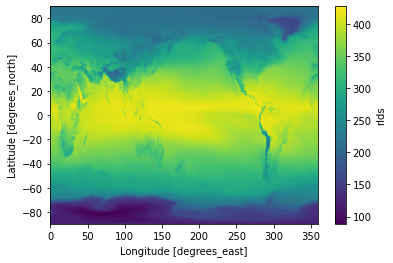

In [11]:
ds['rlds'].mean('time').plot()

In [16]:
def preprocess(ds):
    filename = ds.encoding["source"]
    # Rename variable
    title = re.search(r'\.(.*?)\.', filename).group(1)
    num = title[0:3]
    new = title[4:]
    orig = 'var'+str(int(num))
    # Respecify time (set to approx. middle of month)
    year = re.search(r'01_(.*?)12.nc', filename).group(1)
    times = pd.date_range(year+'-01-16',periods=12,freq='M')-pd.DateOffset(days=15)
    return ds.rename({orig:new}).assign_coords({'time':times})

In [17]:
ds = xr.open_mfdataset(pathsnow,preprocess=preprocess)
ds = ds.sortby('lat').chunk({'time':120})

In [21]:
ds_wmt = xr.Dataset()
# Calculate terms
ds_wmt['tos'] = ds['brtmp'].where(ds['icec']==0)-273.15 # Mask out under-ice
ds_wmt['hfds'] = (ds['dlwrf']-ds['ulwrf']+ds['dswrf']-ds['uswrf']-ds['lhtfl']-ds['shtfl'])
conv = (1/1000)*1000*(1/86400) # mm d-1 ---> kg m-2 s-1
ds_wmt['wfo'] = (ds['tprat']-ds['evp'])*conv

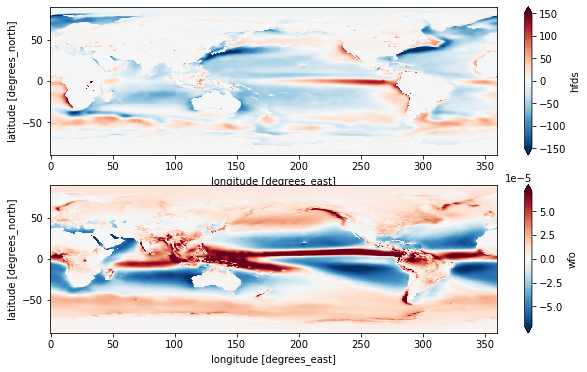

In [22]:
fig,(ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2)
ds_wmt['hfds'].isel(time=slice(-240,-1)).mean('time').plot(ax=ax1,robust=True,vmin=-150,vmax=150,cmap='RdBu_r')
ds_wmt['wfo'].isel(time=slice(-240,-1)).mean('time').plot(ax=ax2,robust=True)

In [23]:
### Get SoS from en4
sos = xr.open_zarr(rootdir_sos+'jra55.zarr')['salinity']
sos_wmt = (sos.
           sel(time=ds['time'],method='nearest',drop=True).
           assign_coords(ds.coords).
           chunk({'time':120}))
ds_wmt['sos'] = sos_wmt

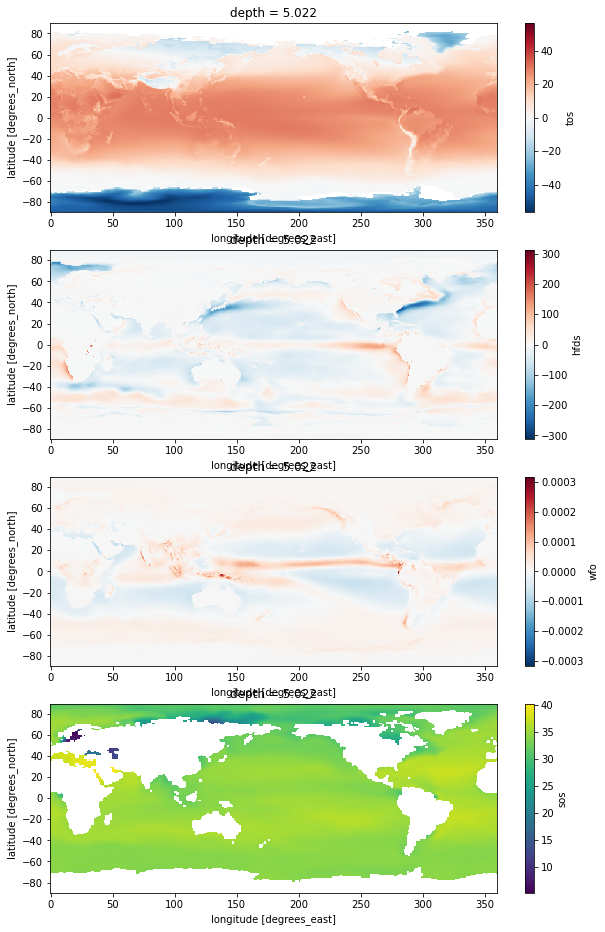

In [24]:
nv = len(ds_wmt.data_vars)
fig,ax = plt.subplots(figsize=(10,4*nv),nrows=nv)
for i,varname in enumerate(ds_wmt.data_vars):
    da = ds_wmt[varname].isel(time=slice(0,120)).mean('time')
    da.plot(ax=ax[i])

In [25]:
with ProgressBar():
    ds_wmt.to_zarr(rootdir_wmt+'jra55.en4.ds.zarr',mode='w')

[########################################] | 100% Completed | 69.00 s
